In [9]:
import torchmetrics
import torch
from torch import nn
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

In [10]:
from datasets import load_dataset
import numpy as np

transformer_name = "microsoft/beit-base-patch16-224"


train_dataset = load_dataset("DGE_training", data_dir="*/", split="train").shuffle()

#labels = train_dataset.features["label"].names

from transformers import AutoFeatureExtractor, BeitFeatureExtractor

feature_extractor = BeitFeatureExtractor.from_pretrained(transformer_name)



Resolving data files: 100%|██████████| 476/476 [00:00<00:00, 237988.88it/s]
Using custom data configuration DGE_training-1a4881cf19cc1a09
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_training-1a4881cf19cc1a09\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


In [11]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, RandomRotation, Resize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomRotation(degrees=180, expand=False), RandomResizedCrop(size=224), Resize(feature_extractor.size), ToTensor(), normalize])

In [12]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

train_dataset = train_dataset.with_transform(transforms)

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, BeitForImageClassification
from datasets import load_metric

model = BeitForImageClassification.from_pretrained(
    transformer_name,
    num_labels=5,
    ignore_mismatched_sizes=True,
)

device = 'cuda'
model = model.to(device)


from datasets import load_metric

model.cuda()

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

In [14]:
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

train_df = pd.read_csv('train_data.csv',dtype=str)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
print(class_weights)

[5.95       0.952      0.43272727 0.7616     6.34666667]


In [15]:
from torchvision import datasets

#training_dataset_pt = datasets.ImageFolder(root="DGE_training", transform=transforms)
dataset_size = len(train_dataset[:]['label'])
#train_count = int(dataset_size * 0.7)
#val_count = dataset_size - train_count
#train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_dataset, [train_count, val_count])

#print(train_dataset[0])
import numpy as np 

#y_train_indices = train_dataset["train"].indices

y_train = train_dataset[:]['label']

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, sampler=sampler)
#val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, sampler=sampler)

print(len(train_dataloader.dataset))
#print(len(val_dataloader.dataset))

#print(val_dataloader)

476


In [16]:
from transformers import AdamW
from datasets import load_metric


model.train()

optim = AdamW(model.parameters(), lr=2e-5)
size = len(train_dataloader.dataset)

train_df = pd.read_csv('train_data.csv',dtype=str)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
loss_fct = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(class_weights))


accuracy_tracker = []
accuarcy_tracker_val = []
loss_tracker = []
for epoch in range(70):
    acc_train = load_metric('accuracy')
    acc_val = load_metric('accuracy')

    for batch in train_dataloader:
        optim.zero_grad()
        #input_ids = batch['input_ids'].to(device)
        #attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'), labels=labels)
        loss = loss_fct(outputs[1], labels)
        #loss_tracker.append(loss)
        #loss = loss_fct(outputs[1].view(-1, model.config.num_labels), labels.view(-1)) #difference between this and the above line?
        #loss = outputs[0]
        loss.backward() 
        optim.step()
        
        acc_train.add_batch(predictions=np.argmax(outputs[1].cpu().detach().numpy(), axis=-1), references=labels)
    # for batch_val in val_dataloader:
    #     labels = batch_val['label'].to(device)
    #     outputs = model(batch_val['pixel_values'].type('torch.cuda.FloatTensor'), labels=labels)
    #     loss_val = loss_fct(outputs[1], labels)
    #     acc_val.add_batch(predictions=np.argmax(outputs[1].cpu().detach().numpy(), axis=-1), references=labels)


    print(epoch)
    #print(metric.compute())
    accuracy_tracker.append(acc_train.compute()['accuracy'])
    loss_tracker.append(loss)
    #accuarcy_tracker_val.append(acc_val.compute()['accuracy'])
    print(accuracy_tracker[-1])
    #print(metric)
    model.eval()

0
0.38445378151260506
1
0.5777310924369747
2
0.6533613445378151
3
0.6827731092436975
4
0.7100840336134454
5
0.726890756302521
6
0.7962184873949579
7
0.7521008403361344
8
0.7668067226890757
9
0.8214285714285714
10
0.8277310924369747
11
0.7878151260504201
12
0.819327731092437
13
0.8004201680672269
14
0.8340336134453782
15
0.8067226890756303
16
0.8151260504201681
17
0.8613445378151261
18
0.8592436974789915
19
0.8760504201680672
20
0.8739495798319328
21
0.884453781512605
22
0.8676470588235294
23
0.8802521008403361
24
0.8823529411764706
25
0.9138655462184874
26
0.9369747899159664
27
0.8613445378151261
28
0.907563025210084
29
0.8739495798319328
30
0.9033613445378151
31
0.9117647058823529
32
0.8571428571428571
33
0.8802521008403361
34
0.9222689075630253
35
0.8928571428571429
36
0.9180672268907563
37
0.9243697478991597
38
0.8949579831932774
39
0.8340336134453782
40
0.9054621848739496
41
0.9054621848739496
42
0.9222689075630253
43
0.9201680672268907
44
0.9390756302521008
45
0.930672268907563
46

In [17]:
# model = torch.load('VIT_models\\BEiT_90.pt')
# model.to('cuda')
# model.eval()
#normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_test_transforms = Compose([Resize(feature_extractor.size), ToTensor(), normalize])
def test_transforms(examples):
    examples["pixel_values"] = [_test_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples


test_dataset = load_dataset("DGE_test", data_dir="*/", split="train")
test_dataset = test_dataset.train_test_split(test_size=0.01)
test_dataset["train"][0]
labels = test_dataset["train"].features["label"].names
test_dataset = test_dataset.with_transform(test_transforms)

test_dataloader = torch.utils.data.DataLoader(test_dataset['train'], batch_size=8)

Resolving data files: 100%|██████████| 2950/2950 [00:00<00:00, 19662.25it/s]
Using custom data configuration DGE_test-14758c97f2c96edf
Reusing dataset imagefolder (C:\Users\zacha\.cache\huggingface\datasets\imagefolder\DGE_test-14758c97f2c96edf\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


Text(0.5, 1.0, 'Accuracy Between Epochs (Training Dataset)')

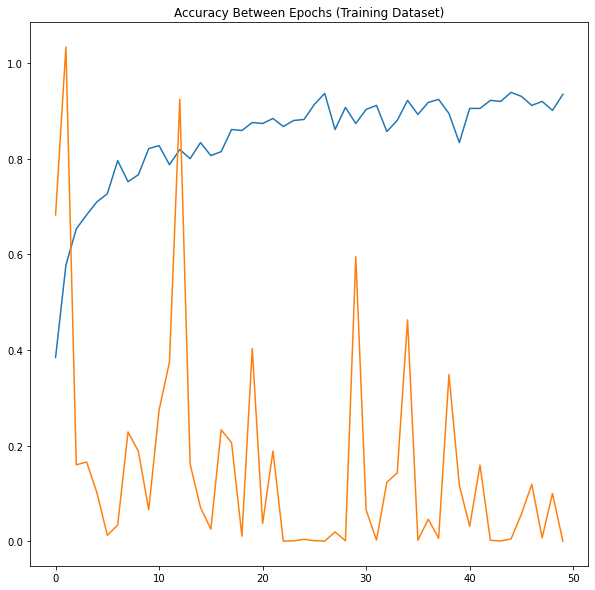

In [18]:
loss_tracker_cpu = []
for i in range(len(loss_tracker)):
    loss_tracker_cpu.append(loss_tracker[i].cpu().detach().numpy())


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(accuracy_tracker)
plt.plot(loss_tracker_cpu)
plt.title('Accuracy Between Epochs (Training Dataset)')

In [19]:
torch.save(model, 'VIT_models\BEiT_90.pt')

In [20]:
metric = load_metric('accuracy')
y_pred = []
y_true = []
for batch in test_dataloader:
    labels = batch['label'].to(device)
    outputs = model(batch['pixel_values'].type('torch.cuda.FloatTensor'), labels=labels)
    predictions=np.argmax(outputs[1].cpu().detach().numpy(), axis=-1)
    y_pred.append(predictions)
    y_true.append(labels.cpu().detach().numpy())
    metric.add_batch(predictions=predictions, references=labels)
print(metric.compute())

{'accuracy': 0.3253424657534247}


In [21]:
y_true_total = []
for i in range(len(y_true)):
    for j in range(len(y_true[i])):
        y_true_total.append(y_true[i][j])

y_pred_total = []
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        y_pred_total.append(y_pred[i][j])

print(len(y_pred_total))
print(len(y_true_total))

2920
2920


Model accuarcy is:  0.3253424657534247
Model precision is:  0.30778085783049686
Model f1_score is:  0.18721275301555024
Model recall is:  0.1716994498984438
Model MSE is:  1.6363013698630138
Confusion Matrix
[[112 158 229   0   0]
 [  7  12 138   8  36]
 [  1 502 818  60  88]
 [  0 224 187   8  38]
 [  0   0 290   4   0]]


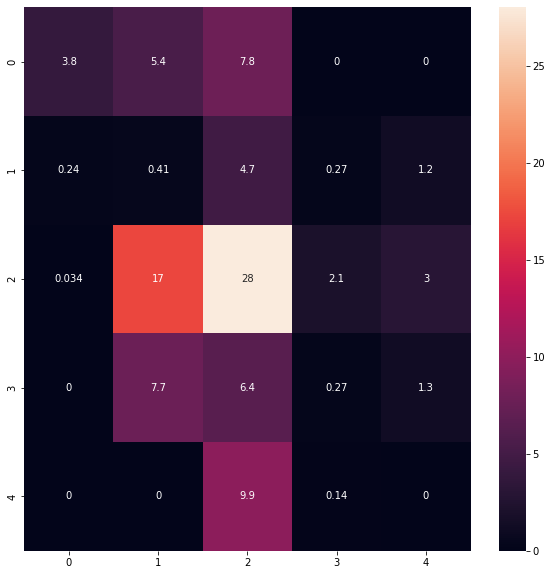

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn


cf_matrix = confusion_matrix(y_true_total, y_pred_total)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = range(0, 5),
                     columns = range(0, 5))


plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True)



import sklearn
#metrics
accuarcy = sklearn.metrics.accuracy_score(y_true_total, y_pred_total)
print('Model accuarcy is: ', accuarcy)
precision = sklearn.metrics.precision_score(y_true_total,y_pred_total, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_true_total,y_pred_total, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_true_total,y_pred_total, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_true_total,y_pred_total)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(cf_matrix)

In [23]:
# model = torch.load('VIT_models\\BEiT_90.pt')
# model.eval()